# LineWorld MDP

This notebook provides a proof of concept of behavior initialization. Agents are simulated in the 1D LineWorld from [Kumar et. al.](https://bair.berkeley.edu/blog/2019/12/05/bear/) and demonstrate the neccessity for data collection. 

### Imports

In [58]:
import numpy as np
import torch
import random
import math
import time
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(2)

### The 1D Line World MDP

In [59]:
class LineWorldMDP:
    def __init__(self, num_states):
        # initialize MDP
        self.end           = False
        self.current_state = 1
        self.num_actions   = 2
        self.num_states    = num_states
        self.step_count = 0

    def reset(self):
        # reset MDP
        self.step_count = 0
        self.end = False
        self.current_state = 1
        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1.
        return state

    def step(self, action):
        # increment step count
        self.step_count += 1

        # positive reward for right action
        if action == 1:
            self.current_state += 1
            reward = 1
        # negative reward for left action
        else:
            self.current_state -= 1
            reward = -1
            self.end = True

        # check step counter
        if self.step_count >= 1000 or self.current_state==self.num_states:
            self.end = True

        state = np.zeros(self.num_states)
        state[self.current_state - 1] = 1
        return state, reward, self.end, {}


### Neural Network Architecture

In [60]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Net, self).__init__()
        self.num_actions = num_actions
        self.l1 = nn.Linear(num_inputs, 32)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(32, num_actions)

    def forward(self, states):
        x = to_torch(states)
        x = to_torch(x)
        x = self.l1(x)
        x = self.relu2(x)
        x = self.l3(x)
        return x
    
    def get_actions(self, steps, states):
        if random.random() > 0.001 + (0.4 - 0.001) * math.exp(-1. * steps / 200):
            x = to_torch(states)
            x = self.forward(x)
            x = torch.argmax(x).type(torch.int64)
            return x
        else:
            return to_torch(np.random.randint(low=0, high=self.num_actions)).type(torch.int64)


def to_torch(x, **kwargs):
	if torch.is_tensor(x):
		return x.to(DEVICE)
	else:
		return torch.tensor(x, device=DEVICE, dtype=torch.float32, **kwargs)


### Replay Buffer

In [61]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def empty(self):
        while self.buffer:
          _ = self.buffer.pop()

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)


### Train using Q-Learning

In [62]:
def train(replay_buffer, agent):
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    states = to_torch(states)
    actions = to_torch(actions).type(torch.int64)
    rewards = to_torch(rewards)
    next_states = to_torch(next_states)
    dones = to_torch(dones)
    vals = agent(states)
    vals = vals.gather(1, actions.unsqueeze(1))
    next_vals = agent(next_states).max(1)[0]
    target = rewards + gamma*next_vals*(1 - dones)
    td_error = (target.detach() - vals).pow(2).mean()
    optimizer.zero_grad()
    td_error.backward()
    optimizer.step()
    return td_error.item()    


### Simulate Agent in Environment

In [63]:
def main(env, model, replay_buffer, data_collect):
    log_dict = {}
    log_dict['rewards'] = []
    log_dict['average_rewards'] = []
    log_dict['average_error'] = []
    log_dict['td_error'] = []
    log_dict['ep_count'] = []
    state = env.reset()
    loss = torch.FloatTensor([0])
    steps = 0
    ep_step_count = 0
    ep_reward = 0
    ep_loss = 0
    while steps < num_steps:
        action = model.get_actions(steps, state)
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        steps += 1
        ep_step_count += 1

        if len(replay_buffer) > batch_size:
            loss = train(replay_buffer, model)
        ep_loss += loss

        if steps%data_collect==0:
            replay_buffer.push(state, action, reward, next_state, done)
        state = next_state

        if done:
            state = env.reset()
            ep_step_count = 0
            done = False
            log_dict['rewards'].append(ep_reward)
            log_dict['td_error'].append(ep_loss)
            if len(log_dict['rewards']) > window_size:
                log_dict['average_rewards'].append(np.mean(log_dict['rewards'][-window_size:]))
                log_dict['average_error'].append(np.mean(log_dict['td_error'][-window_size:]))
            log_dict['ep_count'].append(steps)
            ep_loss = 0
            ep_reward = 0
        
        if steps % log_interval==0:
            print('\tSteps: ', steps,'/', num_steps,'\tReward:', 
                log_dict['rewards'][-1],'\tMax Reward:',max(log_dict['rewards']),'\tTD Error:',log_dict['td_error'][-1],'\tTime:', time.time() - start_time)

    return log_dict    


## Plotting utilities

In [64]:
def res_plot(log_dir, log_dir_off):
	# plot rewards
    fig = plt.figure()
    plt.title('Average Returns', fontsize=24)
    plt.plot(log_dir['average_rewards'][-200:])
    plt.plot(log_dir_off['average_rewards'][-200:])
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('Returns', fontsize=18)
    plt.legend(['No Dataset','Sub-Optimal Dataset'])
    plt.show()
    fig.savefig('plot_rewards.png', dpi=600, bbox_inches='tight')

def plot_regret(log, log_off):
	# plot rewards
    fig = plt.figure()
    plt.title('Regret', fontsize=24)
    regret = []
    regret_off = []
    for j in regret_states:
        regret.append(j - max(log[j]))
        regret_off.append(j - max(log_off[j]))
    plt.plot(regret_states, regret)
    plt.plot(regret_states, regret_off)
    plt.xlabel('States', fontsize=18)
    plt.ylabel('Average Regret', fontsize=18)
    plt.legend(['No Dataset','Sub-Optimal Dataset'])
    plt.show()
    fig.savefig('plot_regret.png', dpi=600, bbox_inches='tight')


## Experiment-1

### Train Agent without a dataset

In [71]:
# hyperparameters
lr = 0.001
gamma = 0.95
batch_size = 32
num_states = 200
num_steps = 20000
window_size = 20
log_interval = 1000
buffer_size = 1000
start_time = time.time()

# initialize env and agent
env = LineWorldMDP(num_states=num_states)
model = Net(env.num_states, env.num_actions)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
replay_buffer = ReplayBuffer(buffer_size)

# train agent without a dataset
log_dict = main(env, model, replay_buffer, data_collect=20)
replay_buffer.empty()

	Steps:  1000 / 20000 	Reward: 2 	Max Reward: 16 	TD Error: 2.1893310248851776 	Time: 0.8530707359313965
	Steps:  2000 / 20000 	Reward: 60 	Max Reward: 199 	TD Error: 94.58632791042328 	Time: 2.53533673286438
	Steps:  3000 / 20000 	Reward: 199 	Max Reward: 199 	TD Error: 425.14922523498535 	Time: 4.257816314697266
	Steps:  4000 / 20000 	Reward: 199 	Max Reward: 199 	TD Error: 587.8378605246544 	Time: 5.970109701156616
	Steps:  5000 / 20000 	Reward: 41 	Max Reward: 199 	TD Error: 160.80916094779968 	Time: 7.706385850906372
	Steps:  6000 / 20000 	Reward: 199 	Max Reward: 199 	TD Error: 798.7293793261051 	Time: 9.439692735671997
	Steps:  7000 / 20000 	Reward: 199 	Max Reward: 199 	TD Error: 887.3098019361496 	Time: 11.17654800415039
	Steps:  8000 / 20000 	Reward: 199 	Max Reward: 199 	TD Error: 921.3425795435905 	Time: 12.910367965698242
	Steps:  9000 / 20000 	Reward: 199 	Max Reward: 199 	TD Error: 971.9707253277302 	Time: 14.642228364944458
	Steps:  10000 / 20000 	Reward: 199 	Max Rewar

### Train agent with a sub-optimal dataset

In [72]:
# construct dataset of sub-optimal actions
off_replay_buffer = ReplayBuffer(buffer_size)

state = env.reset()
for _ in range(20*batch_size):
  action = 0
  next_state, reward, done, _ = env.step(action)
  off_replay_buffer.push(state, action, reward, next_state, done)
  if done:
    state = env.reset()
    ep_step_count = 0
    done = False

# initialize model and env
off_model = Net(env.num_states, env.num_actions)
optimizer = torch.optim.Adam(off_model.parameters(), lr=lr)

# train agent
log_dict_off = main(env, off_model, off_replay_buffer, data_collect=20)
replay_buffer.empty()

	Steps:  1000 / 20000 	Reward: 1 	Max Reward: 36 	TD Error: 0.21830253675580025 	Time: 38.66565418243408
	Steps:  2000 / 20000 	Reward: 2 	Max Reward: 36 	TD Error: 0.3552292510867119 	Time: 40.36509680747986
	Steps:  3000 / 20000 	Reward: 3 	Max Reward: 36 	TD Error: 0.7345527522265911 	Time: 42.0851993560791
	Steps:  4000 / 20000 	Reward: 3 	Max Reward: 36 	TD Error: 1.5171979665756226 	Time: 43.78539848327637
	Steps:  5000 / 20000 	Reward: 3 	Max Reward: 36 	TD Error: 1.9804703891277313 	Time: 45.4818754196167
	Steps:  6000 / 20000 	Reward: 3 	Max Reward: 36 	TD Error: 2.1286497116088867 	Time: 47.191272497177124
	Steps:  7000 / 20000 	Reward: 3 	Max Reward: 36 	TD Error: 2.824900299310684 	Time: 48.92257809638977
	Steps:  8000 / 20000 	Reward: 3 	Max Reward: 36 	TD Error: 3.281929910182953 	Time: 50.6252007484436
	Steps:  9000 / 20000 	Reward: 3 	Max Reward: 42 	TD Error: 3.7480518221855164 	Time: 52.36815142631531
	Steps:  10000 / 20000 	Reward: 3 	Max Reward: 166 	TD Error: 4.408

### Generate Reward Plot

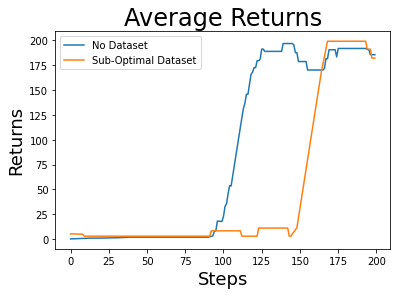

In [73]:
res_plot(log_dict, log_dict_off)

## Experiment-2

### Train Agent without a dataset

In [68]:
lr = 0.001
gamma = 0.95
batch_size = 32
num_steps = 10000
window_size = 20
log_interval = 1000
buffer_size = 1000
start_time = time.time()
regret_states = [10,50,100,200,500,1000]

log = {}
for num_states in regret_states:
    print('Number of States:', num_states, '\n')
    env = LineWorldMDP(num_states=num_states)
    model = Net(env.num_states, env.num_actions)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(buffer_size)
    state = env.reset()

    log_dict = main(env, model, replay_buffer, data_collect=10)
    log[num_states] = log_dict['average_rewards']
    replay_buffer.buffer.clear()


Number of States: 10 

	Steps:  1000 / 10000 	Reward: 3 	Max Reward: 9 	TD Error: 17.14321231842041 	Time: 1.1302087306976318
	Steps:  2000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 31.415761947631836 	Time: 2.727860450744629
	Steps:  3000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 32.89892601966858 	Time: 4.31149697303772
	Steps:  4000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 35.61690974235535 	Time: 5.903691291809082
	Steps:  5000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 32.6036080121994 	Time: 7.494578838348389
	Steps:  6000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 27.37377941608429 	Time: 9.088350057601929
	Steps:  7000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 37.28819823265076 	Time: 10.67218828201294
	Steps:  8000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 32.83616840839386 	Time: 12.273669958114624
	Steps:  9000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 36.287248492240906 	Time: 13.89024019241333
	Steps:  10000 / 10000 	Reward: 9 	Max Reward: 9 	TD Erro

### Train Agent with a sub-optimal dataset

In [69]:
log_off = {}
for num_states in regret_states:
    print('Number of States:', num_states, '\n')
    env = LineWorldMDP(num_states=num_states)
    model_off = Net(env.num_states, env.num_actions)
    optimizer = torch.optim.Adam(model_off.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(buffer_size)
    state = env.reset()

    for _ in range(20*batch_size):
      action = 0
      next_state, reward, done, _ = env.step(action)
      replay_buffer.push(state, action, reward, next_state, done)
      if done:
        state = env.reset()
        ep_step_count = 0
        done = False

    log_dict = main(env, model_off, replay_buffer, data_collect=10)
    log_off[num_states] = log_dict['average_rewards']
    replay_buffer.buffer.clear()


Number of States: 10 

	Steps:  1000 / 10000 	Reward: 6 	Max Reward: 9 	TD Error: 1.1294471994042397 	Time: 104.6955738067627
	Steps:  2000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 3.2874142229557037 	Time: 106.2586042881012
	Steps:  3000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 4.836950957775116 	Time: 107.8581428527832
	Steps:  4000 / 10000 	Reward: 6 	Max Reward: 9 	TD Error: 5.456437349319458 	Time: 109.4478964805603
	Steps:  5000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 8.30287879705429 	Time: 111.02758169174194
	Steps:  6000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 11.304962754249573 	Time: 112.63338041305542
	Steps:  7000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 13.998200178146362 	Time: 114.21691012382507
	Steps:  8000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 19.825987696647644 	Time: 115.83242869377136
	Steps:  9000 / 10000 	Reward: 9 	Max Reward: 9 	TD Error: 30.615776419639587 	Time: 117.4210090637207
	Steps:  10000 / 10000 	Reward: 9 	Max Reward: 9 	

### Generate Regret Plot

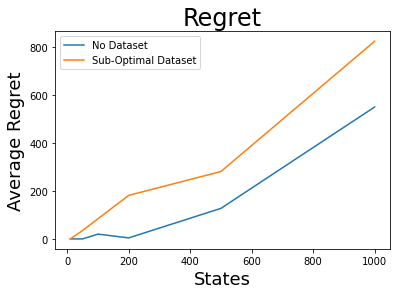

In [70]:
plot_regret(log, log_off)